In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
plt.style.use('ggplot')
from tabulate import tabulate




### Load, examine and clean the data

In [2]:
# Read the dataset

df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.shape

(100000, 9)

In [4]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [5]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

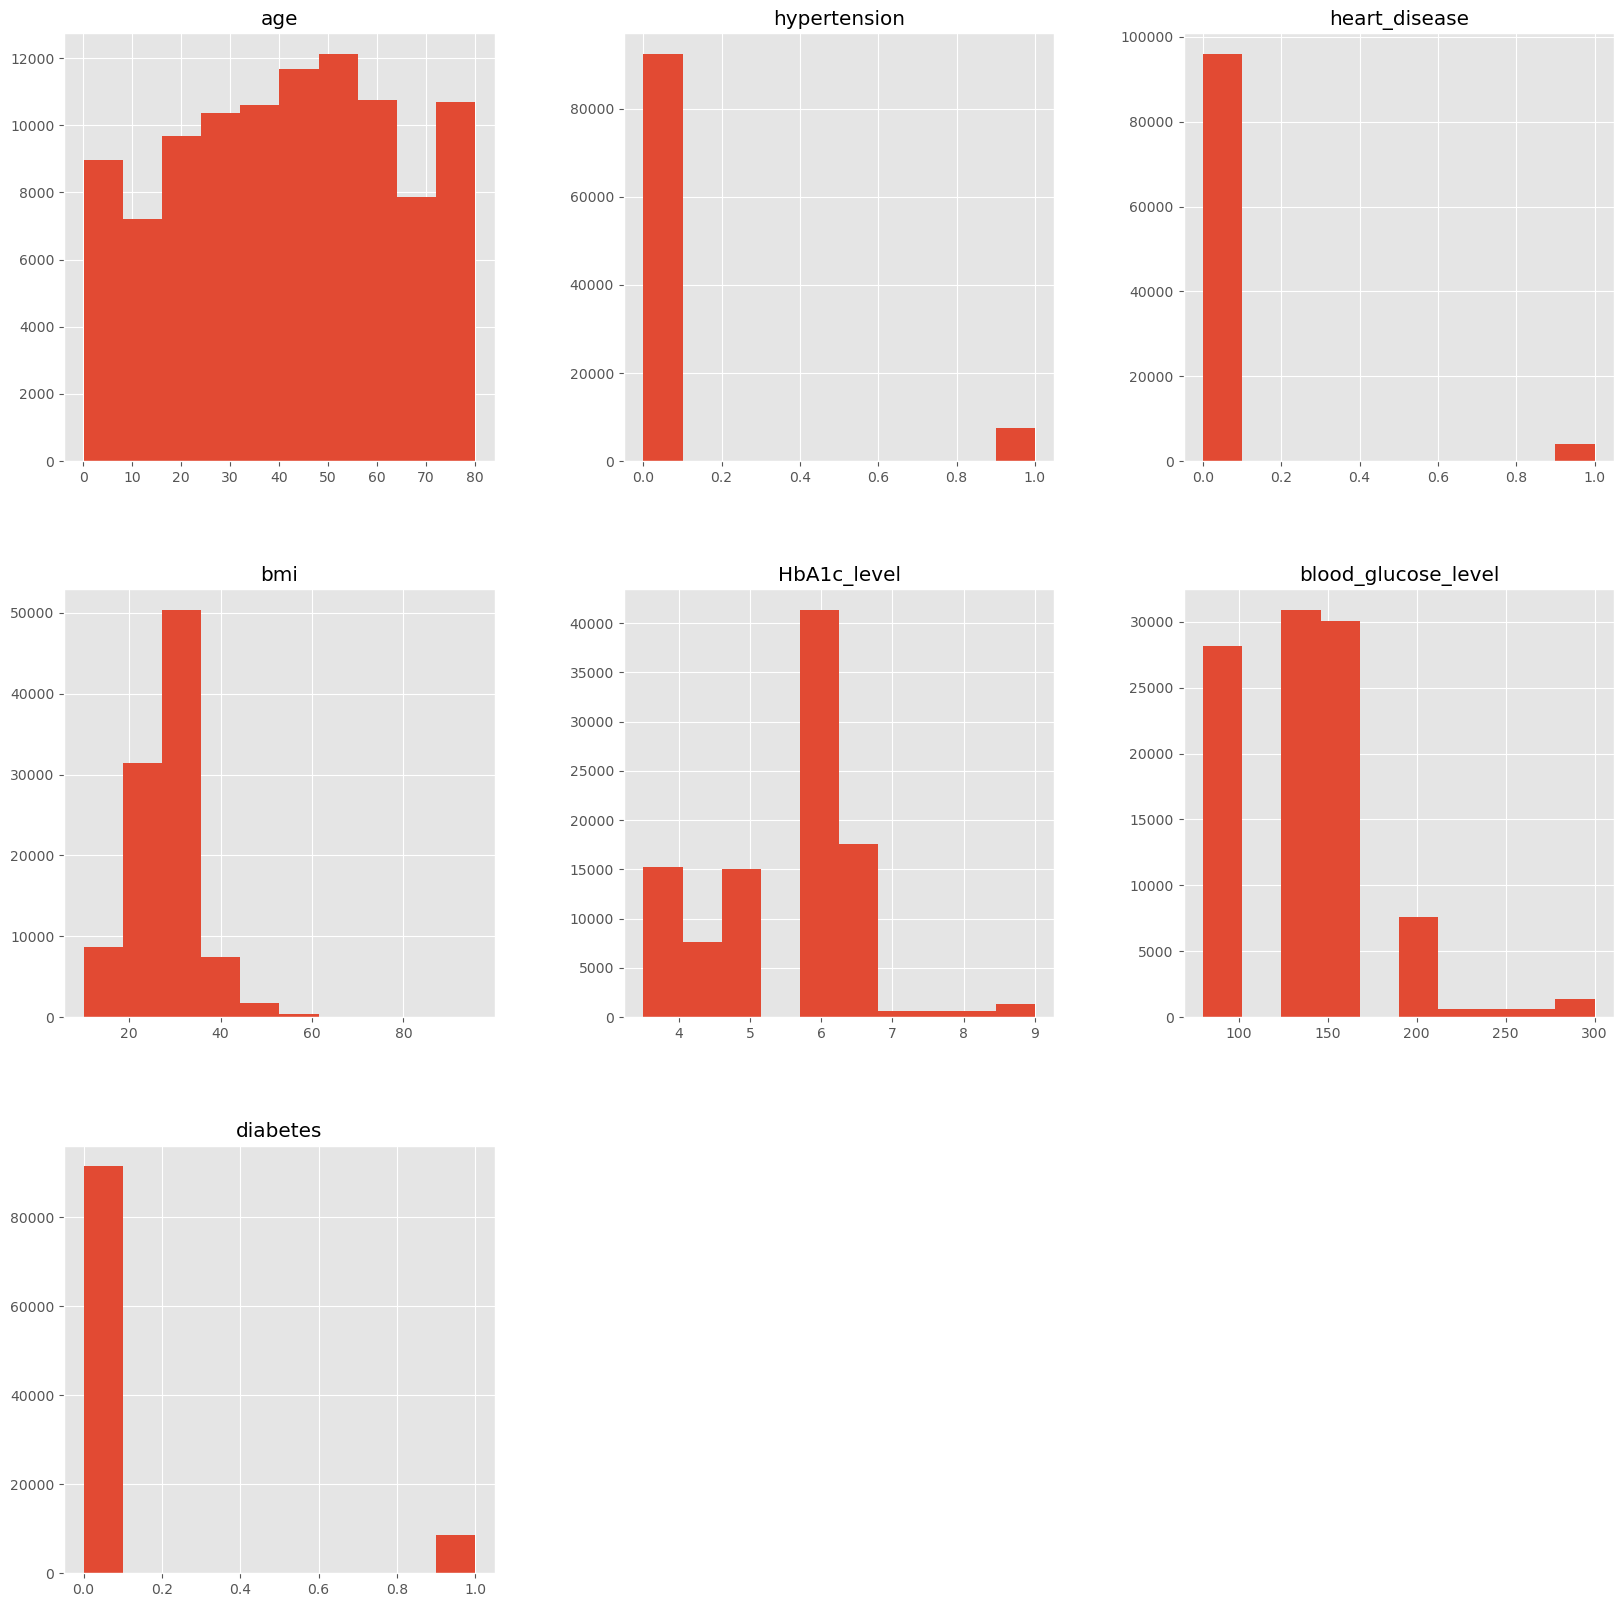

In [6]:
# Plot a histogram for each parameter
df.hist(figsize=(20,20))
plt.show()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.251171,0.233354,0.337396,0.101354,0.110672,0.258008
hypertension,0.251171,1.000000,0.121262,0.147666,0.080939,0.084429,0.197823
heart_disease,0.233354,0.121262,1.000000,0.061198,0.067589,0.070066,0.171727
bmi,0.337396,0.147666,0.061198,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.101354,0.080939,0.067589,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.110672,0.084429,0.070066,0.091261,0.166733,1.000000,0.419558
diabetes,0.258008,0.197823,0.171727,0.214357,0.400660,0.419558,1.000000


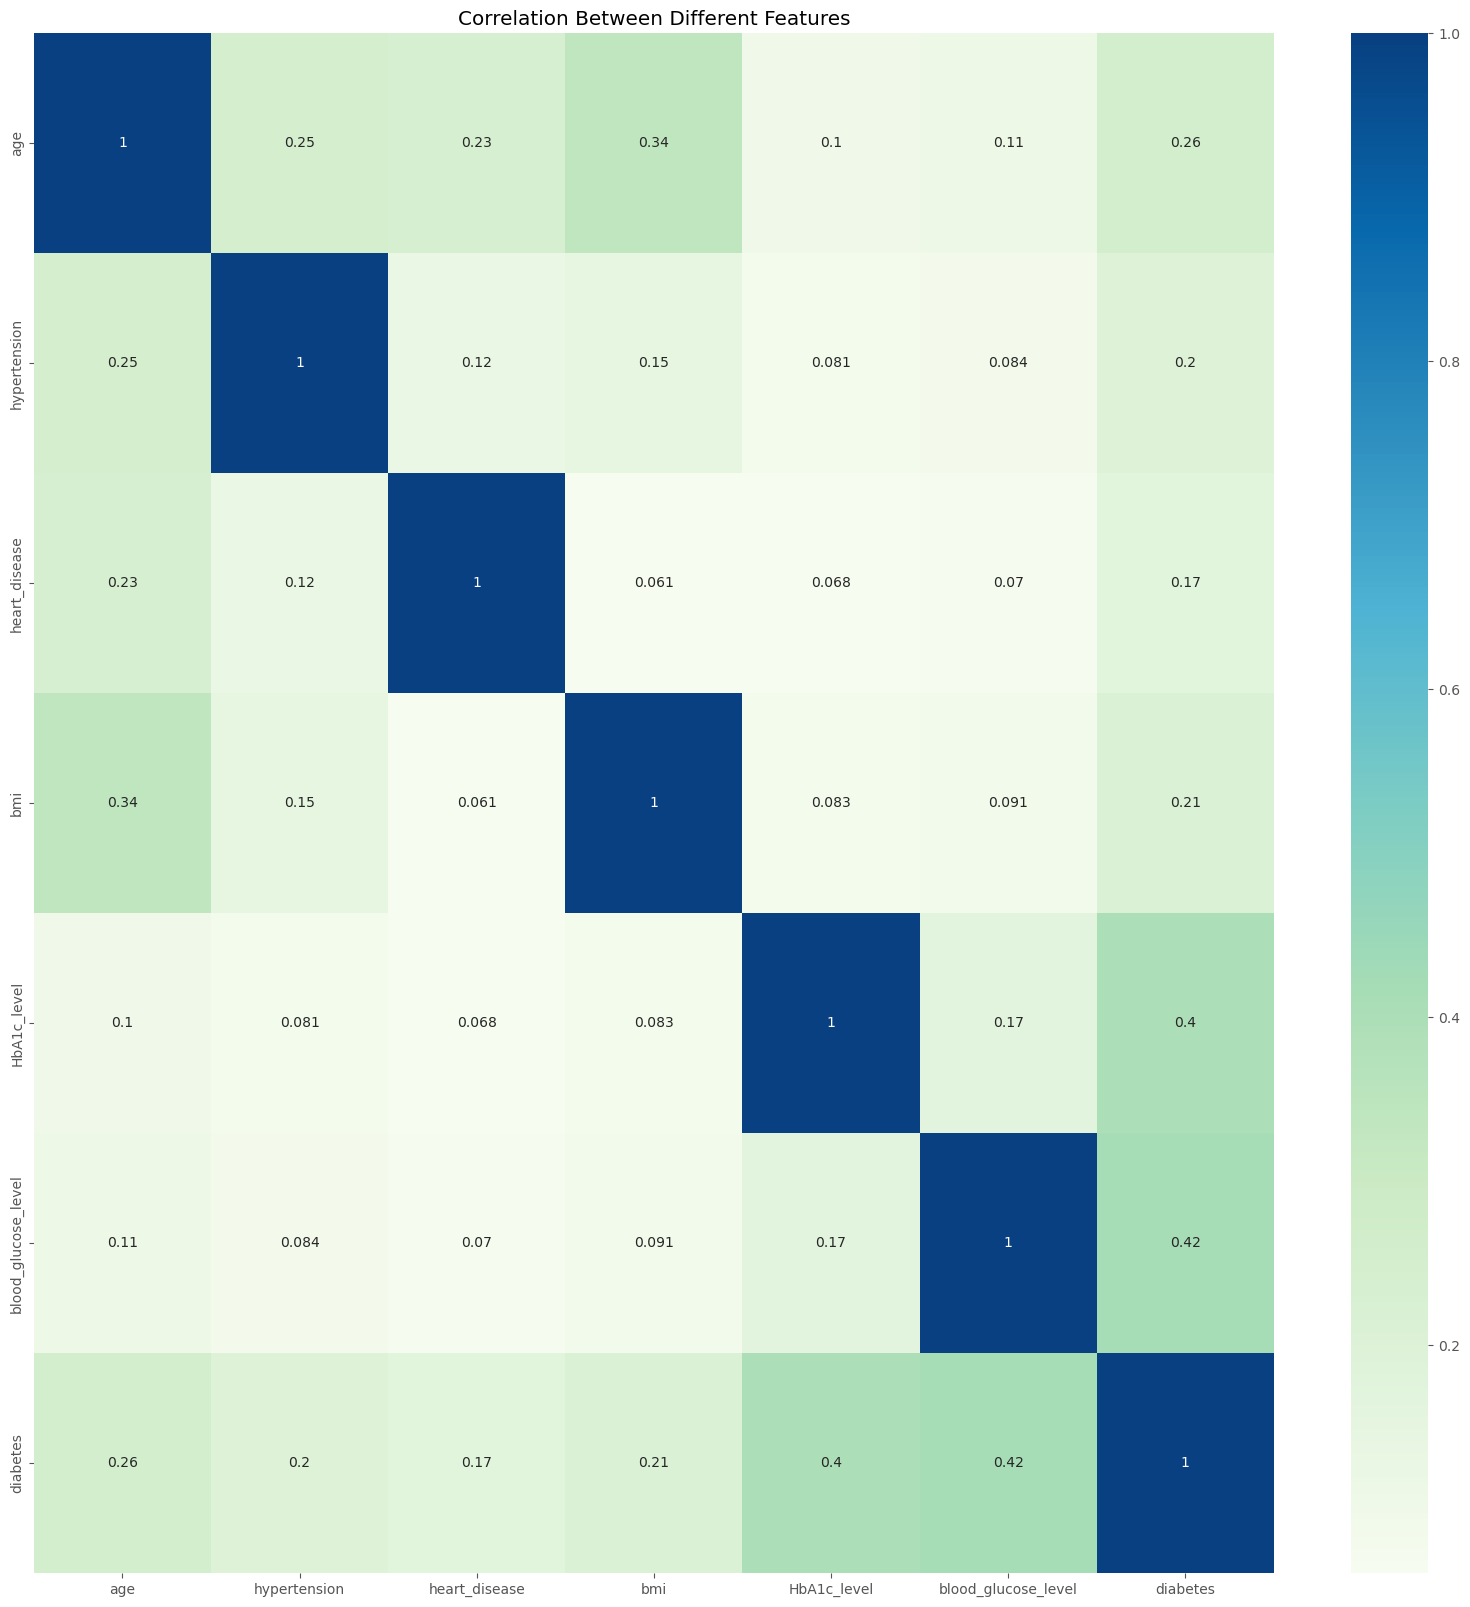

In [7]:
# Look at the correlation of each feature in the dataset

# Calculate the correlation matrix for only numeric columns
corrmat = df.corr(numeric_only=True)
# Get the list of features in the correlation matrix
top_corr_features = corrmat.index

# Set up the figure
plt.figure(figsize=(20,20))

# Generate a heatmap using seaborn library
g = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="GnBu")

plt.title('Correlation Between Different Features')

# Display the correlation matrix
df.corr(numeric_only=True)

##### Observations on Correlations
- Age has a strong positive correlation with hypertension (0.25), heart disease (0.23), and BMI (0.34).
- Hypertension has a moderate positive correlation with heart disease (0.12), BMI (0.15), and diabetes (0.20).
- Heart disease has a weak positive correlation with BMI (0.06), HbA1c level (0.07), blood glucose level (0.07), and diabetes (0.17).
- BMI has a weak positive correlation with HbA1c level (0.08), blood glucose level (0.09), and diabetes (0.21).
- HbA1c level has a strong positive correlation with blood glucose level (0.17) and diabetes (0.40).
- Blood glucose level has the strongest positive correlation with diabetes (0.42).

## K-Means Grouping

K-means clustering can identify previously unknown patterns and relationships in the data, which might not be captured by predefined groups (such as gender, age group, or BMI categories). This can lead to new insights and a deeper understanding of our data.

In [8]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


##### Scale and encode the data

In [9]:
# Use the standard scaler from sklearn to standardize the numeric, non-boolean features
scaled_measures = StandardScaler().fit_transform(df[['bmi', 'HbA1c_level', 'blood_glucose_level']])
scaled_measures_df = pd.DataFrame(scaled_measures, columns=['bmi', 'HbA1c_level', 'blood_glucose_level'])

scaled_measures_df.head()

,bmi,HbA1c_level,blood_glucose_level
0,-0.321056,1.001706,0.047704
1,-0.000116,1.001706,-1.426210
2,-0.000116,0.161108,0.489878
3,-0.583232,-0.492690,0.416183
4,-1.081970,-0.679490,0.416183


In [10]:
# Bring in the scaled features into the original dataset
df2 = df.drop(['bmi', 'HbA1c_level', 'blood_glucose_level'], axis=1)
df2 = pd.concat([df2, scaled_measures_df], axis=1)
df2.head()

,gender,age,hypertension,heart_disease,smoking_history,diabetes,bmi,HbA1c_level,blood_glucose_level
0,Female,80.0,0,1,never,0,-0.321056,1.001706,0.047704
1,Female,54.0,0,0,No Info,0,-0.000116,1.001706,-1.426210
2,Male,28.0,0,0,never,0,-0.000116,0.161108,0.489878
3,Female,36.0,0,0,current,0,-0.583232,-0.492690,0.416183
4,Male,76.0,1,1,current,0,-1.081970,-0.679490,0.416183


In [11]:
# Use pd.get_dummies to convert smoking_history into dummy variables
df3 = pd.get_dummies(df2, columns=['gender','smoking_history'])
df3.head()

,age,hypertension,heart_disease,diabetes,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,0,-0.321056,1.001706,0.047704,1,0,0,0,0,0,0,1,0
1,54.0,0,0,0,-0.000116,1.001706,-1.426210,1,0,0,1,0,0,0,0,0
2,28.0,0,0,0,-0.000116,0.161108,0.489878,0,1,0,0,0,0,0,1,0
3,36.0,0,0,0,-0.583232,-0.492690,0.416183,1,0,0,0,1,0,0,0,0
4,76.0,1,1,0,-1.081970,-0.679490,0.416183,0,1,0,0,1,0,0,0,0


##### Elbow method

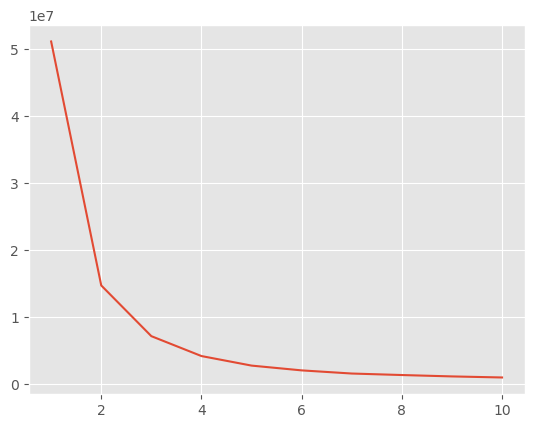

In [12]:
# Use the elbow method to find the optimal number of clusters
inertia = []
k = range(1,11)

# Loop through each cluster and fit the model to the data
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto')
    kmeans.fit(df3)
    inertia.append(kmeans.inertia_)

# Plot the results in a line graph
plt.plot(k, inertia)

##### K-means model to cluster the patients

In [13]:
# fit kmeans object to the dataset
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans.fit(df3)


KMeans(n_clusters=3, n_init='auto', random_state=0)

In [14]:
# predict the labels of clusters
clusters = kmeans.predict(df3)
clusters

array([2, 0, 1, ..., 2, 1, 0], dtype=int32)

In [15]:
# create a new dataframe with the predicted clusters
df4 = df3.copy()
df4['clusters'] = clusters
df4.head()

,age,hypertension,heart_disease,diabetes,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,clusters
0,80.0,0,1,0,-0.321056,1.001706,0.047704,1,0,0,0,0,0,0,1,0,2
1,54.0,0,0,0,-0.000116,1.001706,-1.426210,1,0,0,1,0,0,0,0,0,0
2,28.0,0,0,0,-0.000116,0.161108,0.489878,0,1,0,0,0,0,0,1,0,1
3,36.0,0,0,0,-0.583232,-0.492690,0.416183,1,0,0,0,1,0,0,0,0,0
4,76.0,1,1,0,-1.081970,-0.679490,0.416183,0,1,0,0,1,0,0,0,0,2


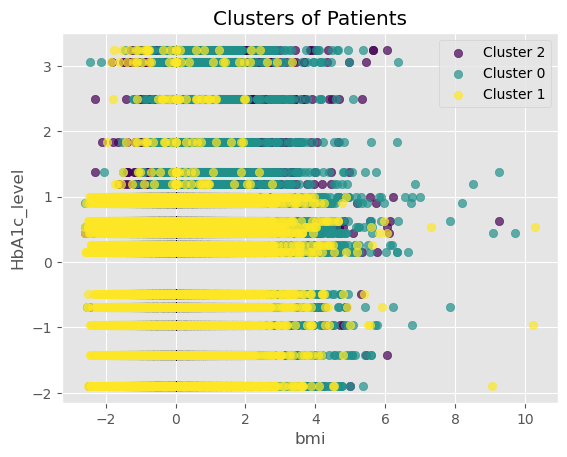

In [16]:
# Get unique clusters and their corresponding colors
unique_clusters = df4['clusters'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plot each cluster with its label
for cluster, color in zip(unique_clusters, colors):
    plt.scatter(df4.loc[df4['clusters'] == cluster, 'bmi'],
                df4.loc[df4['clusters'] == cluster, 'HbA1c_level'],
                c=[color],
                label=f'Cluster {cluster}',
                alpha=0.7)  # You can adjust the transparency using the alpha parameter

# Set labels and title
plt.xlabel('bmi')
plt.ylabel('HbA1c_level')
plt.title('Clusters of Patients')

# Show the legend and plot
plt.legend(loc='upper right')
plt.show()

In [17]:
df5 = df4.copy()
# replace the scaled features with the original features
df5[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]

##### Summary statistics of each cluster

In [18]:
# Group the DataFrame by the 'clusters' column
grouped_df = df5.groupby('clusters')

# Compute summary statistics for numerical variables in each cluster
numerical_summary = grouped_df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']].mean()

# Compute counts for categorical variables (gender) in each cluster
gender_counts = grouped_df[['gender_Female', 'gender_Male', 'gender_Other']].sum()

# Compute the percentage of each gender in each cluster
gender_counts['gender_Female%'] = gender_counts['gender_Female'] / gender_counts.sum(axis=1) * 100
gender_counts['gender_Male%'] = gender_counts['gender_Male'] / gender_counts.sum(axis=1) * 100
gender_counts['gender_Other%'] = gender_counts['gender_Other'] / gender_counts.sum(axis=1) * 100

# Select the percentage columns
gender_summary = gender_counts[['gender_Female%', 'gender_Male%', 'gender_Other%']]

# Compute counts for binary variables (hypertension, heart_disease, and diabetes) in each cluster
yes_no_counts = grouped_df[['hypertension', 'heart_disease', 'diabetes']].sum()

# Compute the percentage of each binary variable in each cluster
yes_no_counts['hypertension%'] = yes_no_counts['hypertension'] / grouped_df.size() * 100
yes_no_counts['heart_disease%'] = yes_no_counts['heart_disease'] / grouped_df.size() * 100
yes_no_counts['diabetes%'] = yes_no_counts['diabetes'] / grouped_df.size() * 100

# Select the percentage columns
yes_no_summary = yes_no_counts[['hypertension%', 'heart_disease%', 'diabetes%']]

# Combine the summaries into a single DataFrame and display them
summary_table = pd.concat([numerical_summary, gender_summary, yes_no_summary], axis=1)

# Round the summary table
summary_table = summary_table.round(2)

# Print the summary table with the tabulate library
print(tabulate(summary_table, headers='keys', tablefmt='rst', floatfmt=".2f"))


==========  =====  =====  =============  =====================  ================  ==============  ===============  ===============  ================  ===========
  clusters    age    bmi    HbA1c_level    blood_glucose_level    gender_Female%    gender_Male%    gender_Other%    hypertension%    heart_disease%    diabetes%
==========  =====  =====  =============  =====================  ================  ==============  ===============  ===============  ================  ===========
         0  44.49  29.23           5.51                 136.85             60.38           39.54             0.02             6.76              1.86         7.15
         1  16.08  24.02           5.41                 133.48             56.83           43.07             0.03             0.40              0.04         0.89
         2  69.50  28.69           5.70                 145.25             58.13           41.78             0.00            17.05             11.51        19.55
==========  =====  =====  ==

#### Cluster Breakdown:

- Cluster 0:
The average age of individuals in this cluster is 44.49 years.
The average BMI is 29.23, which is considered overweight.
The average HbA1c level is 5.51, which is within the normal range.
The average blood glucose level is 136.85.
This cluster has a higher percentage of females (60.38%) compared to males (39.54%) and a very small percentage of other genders (0.02%).
The prevalence of hypertension, heart disease, and diabetes in this cluster is 6.76%, 1.86%, and 7.15%, respectively.

- Cluster 1:
The average age of individuals in this cluster is 16.08 years, which indicates a younger population.
The average BMI is 24.02, which is considered normal weight.
The average HbA1c level is 5.41, which is within the normal range.
The average blood glucose level is 133.48.
This cluster has a higher percentage of females (56.83%) compared to males (43.07%) and a very small percentage of other genders (0.03%).
The prevalence of hypertension, heart disease, and diabetes in this cluster is 0.40%, 0.04%, and 0.89%, respectively, which are relatively low compared to the other clusters.

- Cluster 2:
The average age of individuals in this cluster is 69.50 years, indicating an older population.
The average BMI is 28.69, which is considered overweight.
The average HbA1c level is 5.70, which is within the normal range but slightly higher than the other clusters.
The average blood glucose level is 145.25, which is the highest among the clusters.
This cluster has a higher percentage of females (58.13%) compared to males (41.78%) and no individuals with other gender (0.00%).
The prevalence of hypertension, heart disease, and diabetes in this cluster is 17.05%, 11.51%, and 19.55%, respectively, which are significantly higher compared to the other clusters.

In summary, Cluster 0 consists of middle-aged individuals with a higher percentage of females and moderate prevalence of hypertension, heart disease, and diabetes. Cluster 1 comprises a younger population with relatively low prevalence of these health conditions. Cluster 2 represents an older population with the highest prevalence of hypertension, heart disease, and diabetes among the clusters.

### Logistical regression to predict diabetes

In [19]:
# Separate the features (X) and target (y) variables
X = df4.drop('diabetes', axis=1)
y = df4['diabetes']

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
logreg.fit(X_train, y_train)

# Predict the target variable on the testing data
y_pred = logreg.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(tabulate(confusion, tablefmt="grid"))

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(tabulate(report_df, headers="keys", tablefmt="grid", floatfmt=".2f"))

Accuracy: 0.96

Confusion Matrix:
+-------+------+
| 27202 |  251 |
+-------+------+
|   975 | 1572 |
+-------+------+

Classification Report:
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| 0            |        0.97 |     0.99 |       0.98 |  27453.00 |
+--------------+-------------+----------+------------+-----------+
| 1            |        0.86 |     0.62 |       0.72 |   2547.00 |
+--------------+-------------+----------+------------+-----------+
| accuracy     |        0.96 |     0.96 |       0.96 |      0.96 |
+--------------+-------------+----------+------------+-----------+
| macro avg    |        0.91 |     0.80 |       0.85 |  30000.00 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |        0.96 |     0.96 |       0.96 |  30000.00 |
+--------------+-------------+----------+------------

The provided results show that the logistic regression model has an accuracy of 95.91% on the test dataset. While accuracy is a useful metric, it's essential to consider other metrics, particularly for imbalanced datasets.

From the confusion matrix:

True Negatives (TN): 27,202
False Positives (FP): 251
False Negatives (FN): 975
True Positives (TP): 1,572
Precision, recall, and F1-score can provide additional insights into the model's performance:

Precision (class 1): 0.86 - Of all the instances predicted as positive (diabetic), 86% were actually positive.

Recall (class 1): 0.62 - Of all the actual positive instances (diabetic), the model correctly identified 62%.

F1-score (class 1): 0.72 - The F1-score is the harmonic mean of precision and recall, providing a balance between the two. A higher F1-score indicates better performance.

The model performs well in predicting class 0 (non-diabetic) with high precision, recall, and F1-score. However, for class 1 (diabetic), while the precision is good at 86%, the recall is lower at 62%. This means that the model is more conservative in predicting diabetic cases and misses a considerable proportion of them (false negatives).

Next steps, to minimize false negatives, as failing to identify a diabetic patient could have severe consequences. You can try adjusting the classification threshold, using different models, or applying techniques like oversampling the minority class (e.g., SMOTE) to improve the model's performance, especially for class 1.

In [20]:
# Separate the features (X) and target (y) variables
X = df4.drop('diabetes', axis=1)
y = df4['diabetes']

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after applying SMOTE
class_counts = pd.DataFrame(
    {
        "Before SMOTE": y_train.value_counts(),
        "After SMOTE": y_train_resampled.value_counts(),
    }
)

print("Class Distribution:")
print(tabulate(class_counts, headers="keys", tablefmt="grid", numalign="right"))


Class Distribution:
+----+----------------+---------------+
|    |   Before SMOTE |   After SMOTE |
+====+================+===============+
|  0 |          64047 |         64047 |
+----+----------------+---------------+
|  1 |           5953 |         64047 |
+----+----------------+---------------+


In [22]:
# Train the logistic regression model on the resampled training data
lr2 = LogisticRegression(random_state=42)
lr2.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred2 = lr2.predict(X_test)

# Evaluate the model's performance
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(tabulate(confusion, tablefmt="grid"))

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(tabulate(report_df, headers="keys", tablefmt="grid", floatfmt=".2f"))

Accuracy: 0.8994
Confusion Matrix:
 [[24815  2638]
 [  380  2167]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     27453
           1       0.45      0.85      0.59      2547

    accuracy                           0.90     30000
   macro avg       0.72      0.88      0.77     30000
weighted avg       0.94      0.90      0.91     30000



/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


After applying SMOTE, the logistic regression model's accuracy decreased to 89.94%, but the recall for the positive class (diabetic patients) has increased from 0.62 to 0.85. This means that the model is now better at identifying diabetic patients, which is crucial in medical applications.

However, the precision for the positive class has decreased to 0.45, meaning that there are more false positives (i.e., patients predicted to be diabetic but are not). The F1-score for the positive class has increased from 0.72 to 0.59, showing an overall improvement in the balance between precision and recall.

The model's performance has improved for the minority class (diabetic patients) after applying SMOTE, which is beneficial in this case. Next steps, try other models (e.g., Random Forest, Gradient Boosting Machines, Support Vector Machines)

In [23]:
# Separate the features (X) and target (y) variables
X = df4.drop('diabetes', axis=1)
y = df4['diabetes']

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the SVM model
svm = SVC(random_state=42)

# Train the model on the training data
svm.fit(X_train, y_train)

# Predict the target variable on the testing data
y_pred3 = svm.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred3)
print("Accuracy:", accuracy)

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred3))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred3))



Accuracy: 0.9566
Confusion Matrix:
 [[27382    71]
 [ 1231  1316]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     27453
           1       0.95      0.52      0.67      2547

    accuracy                           0.96     30000
   macro avg       0.95      0.76      0.82     30000
weighted avg       0.96      0.96      0.95     30000



The SVM model with default settings has achieved an accuracy of 95.66%, which is slightly lower than the logistic regression model's accuracy (95.91%) before applying SMOTE. However, the SVM model has higher precision for the positive class (0.95) but lower recall (0.52) compared to the logistic regression model before SMOTE (precision: 0.86, recall: 0.62).

The F1-score for the positive class (diabetic patients) is 0.67, which is lower than the F1-score after applying SMOTE to the logistic regression model (0.72). This suggests that the SVM model is less effective in balancing precision and recall for the minority class compared to the logistic regression model after applying SMOTE.



In [24]:
# Apply same SMOTE to the SVM model
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

# Train the SVM model on the resampled training data
svm2 = SVC(random_state=42)
svm2.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred4 = svm2.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred4))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred4))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred4))



Before SMOTE: 0    64047
1     5953
Name: diabetes, dtype: int64
After SMOTE: 0    64047
1    64047
Name: diabetes, dtype: int64
Accuracy: 0.8853
Confusion Matrix:
 [[24301  3152]
 [  289  2258]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.93     27453
           1       0.42      0.89      0.57      2547

    accuracy                           0.89     30000
   macro avg       0.70      0.89      0.75     30000
weighted avg       0.94      0.89      0.90     30000



After applying SMOTE to the SVM model, the accuracy decreased to 88.53%, but the recall for the positive class (diabetic patients) has significantly increased from 0.52 to 0.89. This means that the model is better at identifying diabetic patients, which is crucial for medical applications.

However, the precision for the positive class has decreased to 0.42, meaning that there are more false positives (i.e., patients predicted to be diabetic but are not). The F1-score for the positive class has decreased from 0.67 to 0.57, which is lower than the F1-score of the logistic regression model after applying SMOTE (0.72).

In summary, the SVM model's performance has improved for the minority class (diabetic patients) after applying SMOTE but is slightly worse than the logistic regression model in balancing precision and recall. You can try tuning the SVM model's hyperparameters (e.g., C, kernel, gamma) to further improve its performance.

You can also try other models like Random Forest, Gradient Boosting Machines, or XGBoost, and compare their performance to choose the best one for your application. Remember to apply SMOTE or another technique for handling class imbalance before training the models.

In [25]:
# XGBoost regression model

# Separate the features (X) and target (y) variables
X = df4.drop('diabetes', axis=1)
y = df4['diabetes']

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=42)

# Train the model on the training data
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing data
y_pred5 = xgb_clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred5)

# Print the accuracy
print("Accuracy:", accuracy)

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred5))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred5))


Accuracy: 0.9707666666666667
Confusion Matrix:
 [[27358    95]
 [  782  1765]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     27453
           1       0.95      0.69      0.80      2547

    accuracy                           0.97     30000
   macro avg       0.96      0.84      0.89     30000
weighted avg       0.97      0.97      0.97     30000



the XGBoost model with SMOTE, the results show that the model has achieved an accuracy of 97.08%. The precision for the positive class (diabetic patients) is 0.95, and the recall is 0.69, which results in an F1-score of 0.80.

These results indicate that the XGBoost model with SMOTE has performed better in terms of accuracy and F1-score for the positive class compared to the logistic regression and SVM models before and after applying SMOTE. This suggests that the XGBoost model with SMOTE is a good choice for this dataset and the problem of predicting diabetes.

Next steps, experiment with tuning the hyperparameters of the XGBoost model to potentially achieve even better results.

In [26]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1.0]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)

# Fit the RandomizedSearchCV object on the SMOTE resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Find the best hyperparameters
best_params = random_search.best_params_
print("Best Parameters: ", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Predict the target variable on the testing data
y_pred_best = best_model.predict(X_test)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred_best)

# Print the accuracy
print("Accuracy:", accuracy)

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Best Parameters:  {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Accuracy: 0.9701333333333333
Confusion Matrix:
 [[27337   116]
 [  780  1767]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     27453
           1       0.94      0.69      0.80      2547

    accuracy                           0.97     30000
   macro avg       0.96      0.84      0.89     30000
weighted avg       0.97      0.97      0.97     30000



The accuracy of the tuned XGBoost model with SMOTE is slightly lower (0.9701) compared to the XGBoost model with SMOTE without hyperparameter tuning (0.9708). The precision, recall, and F1-score for the positive class (1) are very similar for both models.

In summary, both models perform similarly in terms of accuracy and classification metrics. The hyperparameter tuning did not result in a significant improvement in the model's performance.